In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

from ts_pred_helper import *
from model import *
from data import *

/home/asuka/anaconda3/envs/py3/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Non-linear AR(3)

In [ ]:
init_seq = np.array([0.1, 0.2, 0.3])
weights = np.array([0.1, 0.2, 0.7, 0.01])
noise_func = gaussian_noise
data = get_data(data_type='nonlinear_ar', init_seq=init_seq, weights=weights, noise_func=noise_func, normalize=False)
plt.plot(data[200:400, 0])
plt.show()

Model performance v.s. noise

In [2]:
iterations = 3
model_names = ['LinearFFx3', 'FFx3', 'RNNx3', 'Transformerx3']
models = [LinearFF(1, 3, 64), FF(1, 3, 64), RNN(1, 64, 4, 1), Transformer(1, 64, 2, 4, 3)]
init_seq = np.array([0.1, 0.2, 0.3])
weights = np.array([0.1, 0.2, 0.7, 0.01])
noise_func = gaussian_noise

x_ticks = np.linspace(-5, 5, 20)
noise_factors = [10**x_tick for x_tick in x_ticks]


def train_and_save(idx):
    results = {}
    for noise_factor in tqdm(noise_factors):
        weights[-1] = noise_factor
        results[noise_factor] = []
        for i in range(iterations):
            set_seed(i+1)
            data = get_data(data_type='nonlinear_ar', init_seq=init_seq, weights=weights, noise_func=noise_func, normalize=False)
            tys, pys = train_eval1(models[idx], data=data, window_size=3, epochs=200)
            results[noise_factor].append((tys, pys))
    pickle_save(f'results/{model_names[idx]}_res.pkl', results)


def load_and_eval(idx, threhold):
    ff_res = pickle_load(f'results/{model_names[idx]}_res.pkl')
    x_ticks = []
    ys1 = []
    for key, res_list in ff_res.items():
        x_ticks.append(np.log10(key))
        cur_ys = []
        for value in res_list:
            tys, pys = value
            cur_y = rmse(pys, tys)
            if cur_y > threhold:
                cur_y = threhold
            cur_ys.append(cur_y)
        ys1.append(np.mean(cur_ys))
    return x_ticks, ys1

In [ ]:
for idx in range(2):
    train_and_save(idx+2)

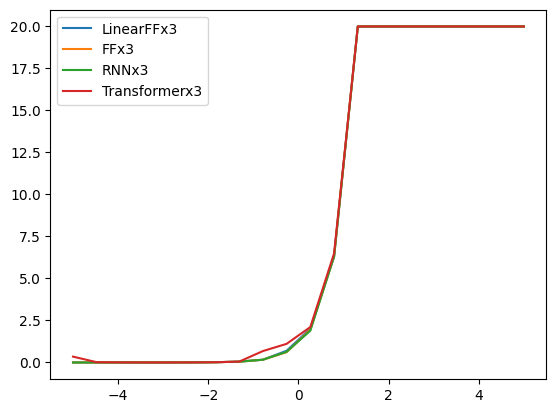

In [3]:
x_ticks = []
threhold = 20

for idx in range(4):
    x_ticks, ys1 = load_and_eval(idx, threhold)
    plt.plot(x_ticks, ys1, label=f'{model_names[idx]}')
plt.legend()
plt.show()